In [40]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
%matplotlib inline 
import tempfile, sys, os
from keras.models import Model
sys.path.insert(0, os.path.abspath('..'))
from matplotlib.ticker import MultipleLocator
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from numpy import loadtxt
from keras.models import load_model
from keras import backend as K
import deepexplain
#from deepexplain.tensorflow import DeepExplain

In [2]:
train = pd.read_csv("data/3Classes_train.csv", sep="\t")
valid = pd.read_csv("data/3Classes_valid.csv", sep="\t")

y_train = train["Global classifier2"]
y_valid = valid["Global classifier2"]

x_train = train["Sequence"].copy()
x_valid = valid["Sequence"].copy()

In [3]:
print(len(x_train), 'train sequences')
print(len(x_valid), 'test sequences')

4015 train sequences
709 test sequences


In [4]:
max_len = len(max(x_train, key=len))
print(max_len)

1500


In [5]:
# all amino acids (in blosum order)
aa = "*ARNDCQEGHILKMFPSTWYVU"
tot_aa = len(aa)

# define a mapping of aa to integers
aa_to_int = dict((c, i) for i, c in enumerate(aa))
int_to_aa = dict((i, c) for i, c in enumerate(aa))

## One hot encoding of Labels

In [6]:
cat = ['Mostly Cytosolic', 'Mostly Nuclear', 'Mostly Organellar']

tot_cat = len(cat)
cat_to_int = {}
int_to_cat = {}
for i in range(tot_cat):
    cat_to_int[cat[i]] = i
    int_to_cat[i] = cat[i]   

In [7]:
def cat_to_indices(Y):
    Y_indices = np.zeros([Y.shape[0],], dtype=int)
    for i in range(len(Y)):
        Y_indices[i] = cat_to_int[Y[i]]
    return Y_indices

# one hot encode
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [8]:
y_train_indices = cat_to_indices(y_train)
y_valid_indices = cat_to_indices(y_valid)

y_train_OH = convert_to_one_hot(y_train_indices, C = tot_cat)
y_valid_OH = convert_to_one_hot(y_valid_indices, C = tot_cat)

## X_train processing: 
### From Sequences to list of indices

In [9]:
# Function to convert sequences to array of indices. I will that that one for embedding 

def seq_to_indices(X, aa_to_int, max_len):
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = []
    
    for i in range(m):                               # loop over training examples
        seq_aa = X[i]
        seq_ind = []
        
        # Loop over the words of sentence_words
        for w in range(len(seq_aa)):
            seq_ind.append(aa_to_int[seq_aa[w]])
            
        X_indices.append(seq_ind)
            
    ### END CODE HERE ###
    
    return X_indices

In [10]:
x_train_indices = seq_to_indices(x_train, aa_to_int, max_len)
x_valid_indices = seq_to_indices(x_valid, aa_to_int, max_len)

In [11]:
# Pad sequences
# By default, the padding is added before the sequence
x_train_pad = sequence.pad_sequences(x_train_indices, maxlen=max_len, value=aa_to_int["*"])
x_valid_pad = sequence.pad_sequences(x_valid_indices, maxlen=max_len, value=aa_to_int["*"])
print('x_train shape:', x_train_pad.shape)
print('x_valid shape:', x_valid_pad.shape)

x_train shape: (4015, 1500)
x_valid shape: (709, 1500)


In [12]:
# One hot to label 
#Y is list of OH vector
def OH_to_label_indices(Y):
    labels = []
    for a in Y:
        indices = np.argmax(a)
        labels.append(indices)
    return labels

In [13]:
def indices_to_cat(Y):
    Y_cat = []
    for i in range(len(Y)):
        Y_cat.append(int_to_cat[Y[i]])
    return Y_cat

# First Model

Saved in model, folder 1 

In [15]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

In [18]:
max_features = tot_aa +1
batch_size = 32

model = Sequential()
model.add(Embedding(max_features, 64, input_length=max_len))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile('NAdam', 'categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='models/1/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                               verbose=1, save_best_only=True)

print('Train...')
model.fit(x_train_pad, y_train_OH,
          batch_size=batch_size,
          epochs=50, 
          class_weight= class_weights,
          validation_data=[x_valid_pad, y_valid_OH],
          callbacks=[checkpointer])

Train...
Train on 4015 samples, validate on 709 samples
Epoch 1/50
4015/4015 [==============================] - 188s 47ms/step - loss: 1.0303 - accuracy: 0.4715 - val_loss: 1.0150 - val_accuracy: 0.4838

Epoch 00001: val_loss improved from inf to 1.01503, saving model to models/1/weights.01-1.02.hdf5
Epoch 2/50
4015/4015 [==============================] - 188s 47ms/step - loss: 0.9846 - accuracy: 0.4984 - val_loss: 1.0159 - val_accuracy: 0.4908

Epoch 00002: val_loss did not improve from 1.01503
Epoch 3/50
4015/4015 [==============================] - 188s 47ms/step - loss: 1.0146 - accuracy: 0.4874 - val_loss: 1.0129 - val_accuracy: 0.4908

Epoch 00003: val_loss improved from 1.01503 to 1.01293, saving model to models/1/weights.03-1.01.hdf5
Epoch 4/50
4015/4015 [==============================] - 187s 47ms/step - loss: 1.0102 - accuracy: 0.4904 - val_loss: 1.0135 - val_accuracy: 0.4894

Epoch 00004: val_loss did not improve from 1.01293
Epoch 5/50
4015/4015 [============================

4015/4015 [==============================] - 187s 47ms/step - loss: 0.4488 - accuracy: 0.8356 - val_loss: 0.6487 - val_accuracy: 0.7518

Epoch 00037: val_loss did not improve from 0.58321
Epoch 38/50
4015/4015 [==============================] - 187s 47ms/step - loss: 0.4410 - accuracy: 0.8354 - val_loss: 0.7038 - val_accuracy: 0.7052

Epoch 00038: val_loss did not improve from 0.58321
Epoch 39/50
4015/4015 [==============================] - 193s 48ms/step - loss: 0.4478 - accuracy: 0.8324 - val_loss: 0.5931 - val_accuracy: 0.7884

Epoch 00039: val_loss did not improve from 0.58321
Epoch 40/50
4015/4015 [==============================] - 188s 47ms/step - loss: 0.4302 - accuracy: 0.8408 - val_loss: 0.6061 - val_accuracy: 0.7757

Epoch 00040: val_loss did not improve from 0.58321
Epoch 41/50
4015/4015 [==============================] - 188s 47ms/step - loss: 0.4213 - accuracy: 0.8488 - val_loss: 0.5922 - val_accuracy: 0.7757

Epoch 00041: val_loss did not improve from 0.58321
Epoch 42/50


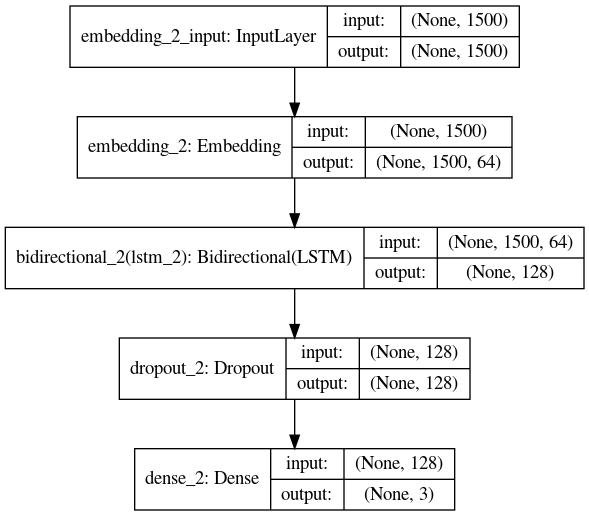

In [21]:
model = load_model('models/1/weights.46-0.58.hdf5')
plot_model(model, to_file='models/1/model_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_labels = indices_to_cat(y_pred_indices)

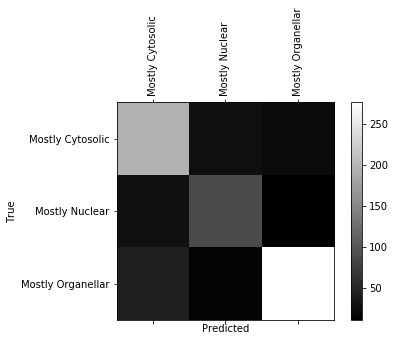

In [29]:
conf_mx = confusion_matrix(y_valid, y_pred_labels, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx, cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

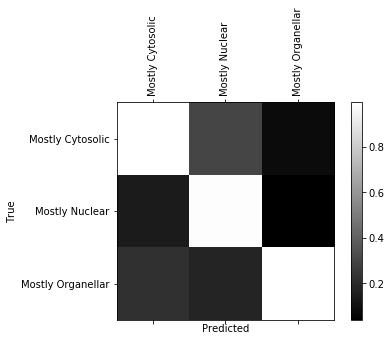

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=0)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Second Model 

I tried Adadelta, but the accuracy improves extremely slowly, same for SGD.
I couldn't reach the same accuracy then with NAdam.
RMSprop and SGD do not learn anything. 

I, therefore, deleted the trained models. Let's keep NAdam

In [37]:
max_features = tot_aa +1
batch_size = 64

model2 = Sequential()
model2.add(Embedding(max_features, 32, input_length=max_len, 
                     name='embedding_layer', trainable=True))
model2.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
model2.add(Dropout(0.15))
model2.add(Dense(3, activation='softmax'))

# try using different optimizers and different optimizer configs
model2.compile('NAdam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='models/2/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                               verbose=1, save_best_only=True)

print('Train...')
history = model2.fit(x_train_pad, y_train_indices,
          batch_size=batch_size,
          epochs=50, 
          class_weight= class_weights,
          validation_data=[x_valid_pad, y_valid_indices],
          callbacks=[checkpointer])

Train...
Train on 4015 samples, validate on 709 samples
Epoch 1/50
4015/4015 [==============================] - 291s 73ms/step - loss: 1.0318 - accuracy: 0.4695 - val_loss: 1.0183 - val_accuracy: 0.4753

Epoch 00001: val_loss improved from inf to 1.01826, saving model to models/2/weights.01-1.02.hdf5
Epoch 2/50
4015/4015 [==============================] - 282s 70ms/step - loss: 1.0354 - accuracy: 0.4892 - val_loss: 0.9986 - val_accuracy: 0.4880

Epoch 00002: val_loss improved from 1.01826 to 0.99863, saving model to models/2/weights.02-1.00.hdf5
Epoch 3/50
4015/4015 [==============================] - 265s 66ms/step - loss: 0.9918 - accuracy: 0.4964 - val_loss: 1.0434 - val_accuracy: 0.4584

Epoch 00003: val_loss did not improve from 0.99863
Epoch 4/50
4015/4015 [==============================] - 265s 66ms/step - loss: 1.0029 - accuracy: 0.4954 - val_loss: 1.0291 - val_accuracy: 0.4753

Epoch 00004: val_loss did not improve from 0.99863
Epoch 5/50
4015/4015 [============================


Epoch 00037: val_loss did not improve from 0.56730
Epoch 38/50
4015/4015 [==============================] - 270s 67ms/step - loss: 1.0389 - accuracy: 0.4585 - val_loss: 1.0375 - val_accuracy: 0.4739

Epoch 00038: val_loss did not improve from 0.56730
Epoch 39/50
4015/4015 [==============================] - 267s 66ms/step - loss: 1.0455 - accuracy: 0.4498 - val_loss: 1.0240 - val_accuracy: 0.4739

Epoch 00039: val_loss did not improve from 0.56730
Epoch 40/50
4015/4015 [==============================] - 263s 65ms/step - loss: 1.0394 - accuracy: 0.4560 - val_loss: 1.0208 - val_accuracy: 0.4753

Epoch 00040: val_loss did not improve from 0.56730
Epoch 41/50
4015/4015 [==============================] - 267s 66ms/step - loss: 1.0197 - accuracy: 0.4772 - val_loss: 0.9820 - val_accuracy: 0.4951

Epoch 00041: val_loss did not improve from 0.56730
Epoch 42/50
4015/4015 [==============================] - 262s 65ms/step - loss: 1.0052 - accuracy: 0.4795 - val_loss: 0.9800 - val_accuracy: 0.4979


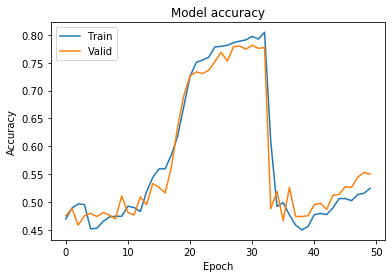

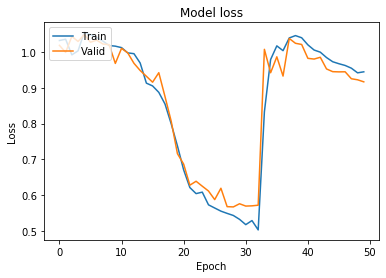

In [38]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

### TO DO:

do PCA of embedding layer, see if it fit to what we would expect.
plot history 
clean weight and commit 

In [46]:
# Get the Embedding Layer
model2 = load_model("models/2/weights.29-0.57.hdf5")
model2 = Model(inputs=model2.input,
              outputs=[model2.output, model2.get_layer('embedding_layer').output])
outputs = model2.predict(x_valid_pad)
model_outputs = outputs[0]
embedding_outputs = outputs[1]

In [49]:
model_outputs.shape

(709, 3)

In [48]:
embedding_outputs.shape

(709, 1500, 32)

In [50]:
embedding_outputs[0]

array([[ 0.01950345, -0.00698717, -0.03422602, ...,  0.02328517,
         0.11123388, -0.120763  ],
       [ 0.01950345, -0.00698717, -0.03422602, ...,  0.02328517,
         0.11123388, -0.120763  ],
       [ 0.01950345, -0.00698717, -0.03422602, ...,  0.02328517,
         0.11123388, -0.120763  ],
       ...,
       [ 0.2505175 , -0.11854098,  0.26884466, ...,  0.3261827 ,
        -0.1384523 ,  0.15345049],
       [ 0.3143646 ,  0.05819634,  0.33928013, ...,  0.2862577 ,
        -0.31684896,  0.3431946 ],
       [ 0.3143646 ,  0.05819634,  0.33928013, ...,  0.2862577 ,
        -0.31684896,  0.3431946 ]], dtype=float32)

In [52]:
embedding_outputs[1]

array([[ 0.01950345, -0.00698717, -0.03422602, ...,  0.02328517,
         0.11123388, -0.120763  ],
       [ 0.01950345, -0.00698717, -0.03422602, ...,  0.02328517,
         0.11123388, -0.120763  ],
       [ 0.01950345, -0.00698717, -0.03422602, ...,  0.02328517,
         0.11123388, -0.120763  ],
       ...,
       [ 0.12531646, -0.1230028 ,  0.13997388, ...,  0.07003798,
         0.13174987, -0.1182822 ],
       [ 0.12531646, -0.1230028 ,  0.13997388, ...,  0.07003798,
         0.13174987, -0.1182822 ],
       [ 0.02594436, -0.05727919,  0.03329619, ...,  0.03527346,
        -0.00517418, -0.01011505]], dtype=float32)

In [53]:
# Transform embedding back to letter
embedding = embedding_outputs[0]
# Use int to aa 

In [55]:
# PCA plots of Embedding 

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(embedding)
embedding_pca = pca.transform(embedding)
print("original shape:   ", embedding.shape)
print("transformed shape:", embedding_pca.shape)

original shape:    (1500, 32)
transformed shape: (1500, 2)


NameError: name 'rows' is not defined

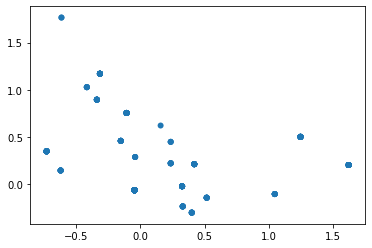

In [56]:
fig, ax = plt.subplots()
plt.scatter(embedding_pca[:, 0], embedding_pca[:, 1], edgecolor='none')

for i, txt in enumerate(rows):
    ax.annotate(txt, (embedding_pca[:, 0][i], embedding_pca[:, 1][i]))
    

plt.show()

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

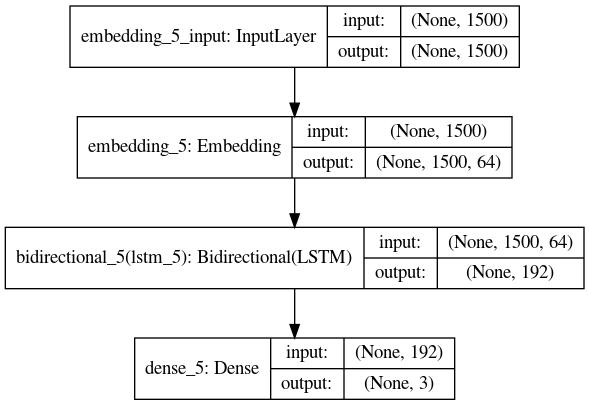

In [34]:
plot_model(model2, to_file='models/2/model_plot.png', show_shapes=True, show_layer_names=True)

In [40]:
# evaluate the model
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_labels = indices_to_cat(y_pred_indices)

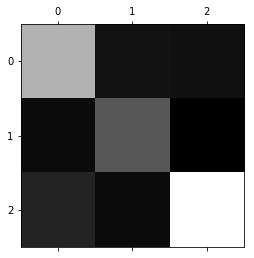

In [41]:
conf_mx = confusion_matrix(y_valid, y_pred_labels, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx, cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Checking the model on the test set

In [ ]:
test = pd.read_csv("data/3Classes_test.csv", sep="\t")
y_test = test["Global classifier2"]
y_test_indices = cat_to_indices(y_test)
y_test_OH = convert_to_one_hot(y_test_indices, C = tot_cat)

x_test = test["Sequence"].copy()
x_test = end_adder(x_test)
x_test_indices = seq_to_indices(x_test, aa_to_int, max_len)
x_test_pad = sequence.pad_sequences(x_test_indices, maxlen=max_len, value=aa_to_int["*"])

In [ ]:
score = model.evaluate(x_test_pad, y_test_OH, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])